In [26]:
# 1. Initialization

import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

model_name = './mnist_model_trained.pt'
trainset_name = './trainset'
testset_name = './testset'

# It was giving problems in the previous version
"""
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
"""
transform = transforms.Compose([transforms.ToTensor()])
criterion = nn.NLLLoss()

# Downloads the dataset for training and for testing
trainset = datasets.MNIST(trainset_name, download=True, train=True, transform=transform)
valset = datasets.MNIST(testset_name, download=True, train=False, transform=transform)
# Loads the datasets into a data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

def view_classify(img, ps):
    """ Function for viewing an image and it's predicted classes.
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [27]:
# [Optional] Print the info of the dataset

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


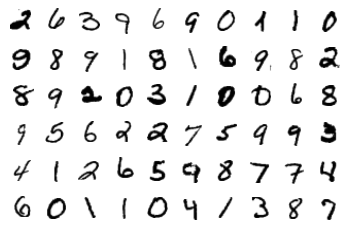

In [28]:
# [Optional] Show a part of the dataset

# Generate next set of images and labels
images, labels = dataiter.next()

# Loop printing each image
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [29]:
# 2. Load or create the model

try:
    model = nn.Sequential(torch.load(model_name))[0]
    print(model_name, 'loaded sucesfully')

except:
    print('Could\'t load', model_name, '. A new empty model have been created')

    # Creates the model with the specified parameters
    input_size = 784
    hidden_sizes = [128, 64]
    output_size = 10

    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

# Initializes the DNN
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = nn.NLLLoss()(logps, labels) #calculate the NLL loss

print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Could't load ./mnist_model_trained.pt . A new empty model have been created
Before backward pass: 
 None
After backward pass: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [30]:
# [Optional] Print the current model

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [31]:
# 3. Train the model (only if the model had to be created) with the MNIST dataset

if model[0].weight.grad is None:
    print('Initializing weights...')
    print('Before backward pass: \n', model[0].weight.grad)
    loss.backward()
    print('After backward pass: \n', model[0].weight.grad)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(1, epochs + 1):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        # This is where the model learns by backpropagating
        loss.backward()

        # And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss / len(trainloader)))
print("\nTraining Time (in minutes) =", (time() - time0) / 60)


Epoch 0 - Training loss: 0.9514510434414787
Epoch 1 - Training loss: 0.33171641351635267
Epoch 2 - Training loss: 0.2724383891280145
Epoch 3 - Training loss: 0.22923033605061616
Epoch 4 - Training loss: 0.19647372782881709
Epoch 5 - Training loss: 0.17102853222680625
Epoch 6 - Training loss: 0.15015403738122252
Epoch 7 - Training loss: 0.13414381073215909
Epoch 8 - Training loss: 0.12021680846850057
Epoch 9 - Training loss: 0.10887827042803995
Epoch 10 - Training loss: 0.0985160400685884
Epoch 11 - Training loss: 0.09004633258611186
Epoch 12 - Training loss: 0.08296062017052269
Epoch 13 - Training loss: 0.07664496900646814
Epoch 14 - Training loss: 0.07122746236852683

Training Time (in minutes) = 1.4132407903671265


In [32]:
# 4. Testing the model with the MNIST dataset

images, labels = next(iter(valloader))

correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if true_label == pred_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count / all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9728


Predicted Digit = 8
True Digit = 8

Correct prediction!


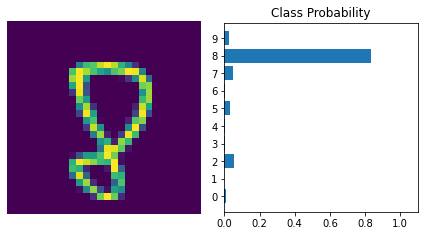

In [33]:
# 5. Testing the model with simple images from dataset

images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
pred_label = probab.index(max(probab))
true_label = labels.numpy()[0]
print("Predicted Digit =", pred_label)
print("True Digit =", true_label)

if pred_label == true_label:
    print("\nCorrect prediction!")
else:
    print("\nWrong prediction :/")
    
view_classify(img.view(1, 28, 28), ps)

In [34]:
# 6. Save the model
torch.save(model, model_name)
print(f'Saved as {model_name}')

Saved as ./mnist_model_trained.pt


In [ ]:
# [Optional] Clean and delete the downloaded datasets

import shutil

try:
    shutil.rmtree(trainset_name)
    shutil.rmtree(testset_name)
    print('Datasets removed successfully')
except:
    print('An error occurred while trying to delete the datasets')